In [1]:
import os

os.chdir("../")
print(os.getcwd())

/rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer


# Read Drag values while training

In [2]:
# def load(filename=None, keys=None):
# #     filename = path.Path(filename)
#     print(f'Loading checkpoint: {filename}')
#     file = open(filename, 'rb')
#     load_data = pickle.load(file)
# #     keys = tuple(data.keys() if keys is None else keys)
#     return load_data
# #     for key in keys:
# #       if key.startswith('_'):
# #         continue
# #       try:
# #         values[key].load(data[key])
# #       except Exception:
# #         print(f'Error loading {key} from checkpoint.')
# #         raise
# #     if self._log:
# #       age = time.time() - data['_timestamp']
# #       print(f'Loaded checkpoint from {age:.0f} seconds ago.')

# data = load(filename = "logdir/Cyl/First_Test/events.out.tfevents.1717606486.cx3-1-0.cx3.hpc.ic.ac.uk.2498444.0.v2")
# print(data.keys())

In [3]:
import yaml
import numpy as np
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# See configs.yaml for all options.
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# Load YAML file
with open('logdir/Cyl_RUN_Imagination_Horizon/Cyl_small_env5_rs1_ihorizon20/config.yaml', 'r') as file:
    loaded_config = yaml.safe_load(file)

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update(loaded_config)

2024-06-21 15:18:52.096648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 15:18:53.016037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reading config
Reading config


In [4]:

logdir_name = config.logdir_basepath+'/'+\
       config.logdir_dirname+'/'+\
       config.logdir_expname
config = config.update({'logdir': logdir_name})
logdir = embodied.Path(config.logdir)
# logdir.mkdirs()
config.save(config.logdir+"/config.yaml")
print('Logdir', logdir)
print("Number of Envs: ", config.envs.amount)

step = embodied.Counter()
logger = embodied.Logger(step, [
  embodied.logger.TerminalOutput(),
  embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
  embodied.logger.TensorBoardOutput(logdir),
  # embodied.logger.MLFlowOutput(logdir.name),
])

############################ Creating Env ##############################


# #make replay
# replay = embodied.replay.Uniform(
#             config.batch_length, config.replay_size, logdir / 'replay')
# eval_replay = make_replay(config, logdir / 'eval_replay', is_eval=True)
# eval_replay = embodied.replay.Uniform(
#               config.batch_length, config.replay_size, logdir / 'eval_replay')
#make env
# env = make_ks_env(config)
from make_flow_envs import make_flow_envs, make_cyl_env
from Cylinder_Env.simulation_base.env import resume_env
from embodied import wrappers
from embodied.envs import from_gym

# env = make_flow_envs(config, env_name="CYL", num_envs = config.envs.amount)
eval_env = resume_env(plot=False,
                      single_run=False,
                      horizon= 200,
                      dump_vtu= 500,
                      dump_debug = 10, 
                      random_start= 10,
                      n_env=1,
                      simulation_duration=100,
                      sim_log_name = config.logdir_dirname+"/"+ \
                                         config.logdir_expname+"/test"
                      )
eval_env = from_gym.FromGym(eval_env, obs_key='vector')  # Or obs_key='vector'.
eval_env = dreamerv3.wrap_env(eval_env, config)
    
eval_env = embodied.BatchEnv([eval_env], parallel=False)

agent = dreamerv3.Agent(eval_env.obs_space, eval_env.act_space, step, config)
args  = embodied.Config(
  **config.run, logdir=config.logdir,
  batch_steps=config.batch_size * config.batch_length)

Logdir /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl_RUN_Imagination_Horizon/Cyl_small_env5_rs1_ihorizon20
Number of Envs:  10


--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           cx3-6-29
  Local device:         mlx5_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `whic

iUFL can be obtained from https://github.com/MiroK/ufl-interpreter
Initialising env number:  1
Number of probes: 64
Simulated 10 iterations before starting the control
--- done buffers initialisation ---
Encoder CNN shapes: {}
Encoder MLP shapes: {'vector': (66,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'vector': (66,)}
JAX devices (1): [CpuDevice(id=0)]
Policy devices: TFRT_CPU_0
Train devices:  TFRT_CPU_0


2024-06-21 15:19:02.398827: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Tracing train function.
Optimizer model_opt has 31,905,090 variables.
Optimizer actor_opt has 5,255,172 variables.
Optimizer critic_opt has 5,512,447 variables.


Loading Checkpoint Model

In [5]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load(config.logdir+'/checkpoint.ckpt', keys=['agent'])

Loading checkpoint: /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl_RUN_Imagination_Horizon/Cyl_small_env5_rs1_ihorizon20/checkpoint.ckpt
Loaded checkpoint from 140104 seconds ago.


Evaluating model with the environment

In [6]:
policy = lambda *args: agent.policy(*args, mode='eval')

In [7]:
from embodied.core.basics import convert
import collections

#initializing actions
_acts = {k: convert(np.zeros((len(eval_env),) + v.shape, v.dtype))
        for k, v in eval_env.act_space.items()}
_acts['reset'] = np.ones(len(eval_env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(eval_env))]
_state = None

In [8]:
from tqdm import tqdm
obs_total = [] 
acts_total = []
control_time = 5 #in env steps
# acts['reset'] = [True]
# obs = env.reset()
for i in tqdm(range(control_time)):
    #take a step
    assert all(len(x) == len(eval_env) for x in _acts.values())
    acts = {k: v for k, v in _acts.items() if not k.startswith('log_')}
    obs  = eval_env.step(acts)

    #read observation
    obs = {k: convert(v) for k, v in obs.items()}
    assert all(len(x) == len(eval_env) for x in obs.values()), obs
    acts, _state = policy(obs, _state)
    acts = {k: convert(v) for k, v in acts.items()}
    
    acts['reset'] = obs['is_last'].copy()
    _acts = acts
    acts_total.append(acts)
#     print(f"{i}: obs: ", obs)
    obs_total.append(obs)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Number of probes: 64
Simulated 10 iterations before starting the control
Tracing policy function.
Tracing policy function.


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


In [26]:
log_specificenv_data = "episode_drags, avg_drag"
actual_env = eval_env.get_actual_env()
se_keys = log_specificenv_data.split(",")



[-0.72098243 -0.72113913 -0.72116762 -0.72122025 -0.72123265 -0.72127748
 -0.72130001 -0.72134048 -0.72136778 -0.72140539 -0.72143573 -0.72147214
 -0.72150487 -0.72154105 -0.72157556 -0.7216121  -0.72164816 -0.72168529
 -0.72172266 -0.72176075 -0.72179931 -0.72183836 -0.72187811 -0.72191817
 -0.72195911 -0.72200024 -0.72204226 -0.72208458 -0.72212768 -0.72217113
 -0.72221535 -0.72225988 -0.72230524 -0.7223509  -0.72239733 -0.72244418
 -0.72249174 -0.72253966 -0.7225883  -0.72263741 -0.72268718 -0.72273737
 -0.72278821 -0.72283959 -0.72289151 -0.72294396 -0.72299707 -0.72305059
 -0.72310477 -0.72315943 -0.72321469 -0.72327048 -0.72332686 -0.72338372
 -0.72344118 -0.72349918 -0.72355771 -0.72361678 -0.72367638 -0.72373652
 -0.72379726 -0.72385848 -0.72403336 -0.72395128 -0.72396225 -0.72396386
 -0.72399664 -0.7240063  -0.72403377 -0.72404832 -0.72407365 -0.72409225
 -0.72411674 -0.72413856 -0.72416306 -0.72418553 -0.72421086 -0.72423524
 -0.72426021 -0.72428548 -0.72431099 -0.72433668 -0

In [17]:
#Collecting Reward and observations
import matplotlib.pyplot as plt

obs_data = obs_total[0]['vector']
obs_reward = obs_total[0]['reward']
acts_data = acts_total[0]['action']
for i in range(1,control_time):
    obs_data   = np.concatenate((obs_data  , obs_total[i]['vector']), axis = 0)
    obs_reward = np.concatenate((obs_reward, obs_total[i]['reward']), axis = 0)
    acts_data  = np.concatenate((acts_data , acts_total[i]['action']) , axis = 0)

# total_obs_data = np.concatenate((u_hist, obs_data), axis = 0)

print("obs_data shape: ", obs_data.shape)
# print("total_obs_data shape: ", total_obs_data.shape)
print("obs_reward shape: ", obs_reward.shape)
print("acts_data shape: ", acts_data.shape)

obs_data shape:  (10, 66)
obs_reward shape:  (10,)
acts_data shape:  (10, 2)


In [20]:
actual_env = eval_env.get_actual_env()
print(actual_env.episode_drags)

[-0.72745496 -0.72763836 -0.72763652 -0.7276715  -0.72765011 -0.72767496
 -0.72766834 -0.72768736 -0.72768766 -0.72770274 -0.72770751 -0.72772098
 -0.72772914 -0.72774231 -0.72775304 -0.72776663 -0.72777945 -0.72779387
 -0.72780848 -0.72782397 -0.72784019 -0.72785687 -0.72787458 -0.72789258
 -0.72791165 -0.72793096 -0.72795135 -0.72797203 -0.72799379 -0.72801578
 -0.72803879 -0.72806209 -0.72808635 -0.72811097 -0.72813648 -0.72816235
 -0.72818905 -0.72821623 -0.72824413 -0.7282725  -0.72830164 -0.72833121
 -0.72836155 -0.7283923  -0.72842377 -0.72845572 -0.72848833 -0.72852141
 -0.72855514 -0.72858942 -0.72862422 -0.72865957 -0.72869551 -0.72873199
 -0.728769   -0.7288065  -0.72884458 -0.72888315 -0.72892231 -0.72896194
 -0.72900212 -0.72904277 -0.72930402 -0.7290889  -0.72905558 -0.72900647
 -0.72901684 -0.7289831  -0.72898179 -0.72895676 -0.72895187 -0.7289331
 -0.72892565 -0.72891122 -0.72890288 -0.72889042 -0.7288807  -0.72887033
 -0.72886086 -0.72885054 -0.72884101 -0.72883075 -0.

Text(0, 0.5, 'Cd')

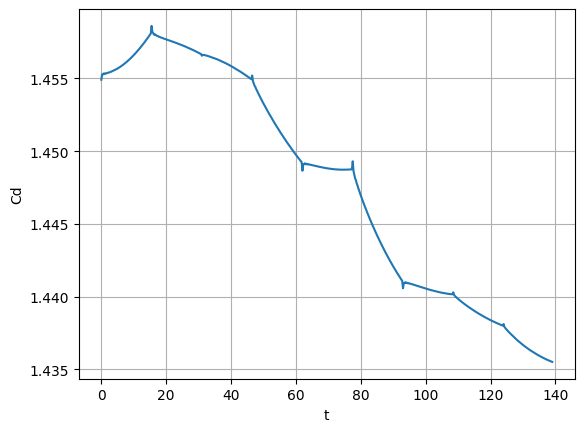

In [21]:
plt.figure()
action_step_dt = 0.25
drag = -2*np.array(actual_env.episode_drags)
plt.plot(np.arange(drag.shape[0])*action_step_dt,drag)
plt.grid()
plt.xlabel("t")
plt.ylabel("Cd")

Text(0, 0.5, 'Reward')

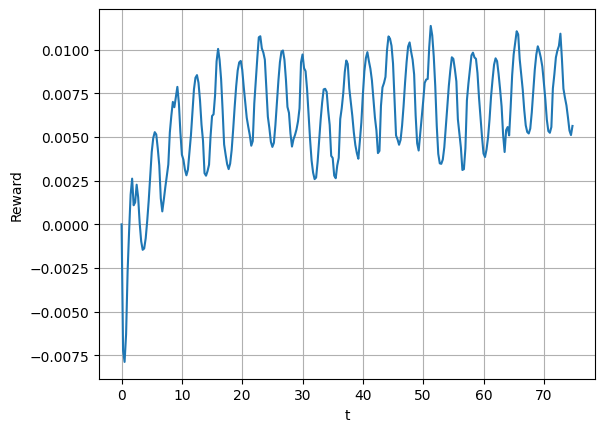

In [71]:
plt.figure()
action_step_dt = 0.25
plt.plot(np.arange(obs_reward.shape[0])*action_step_dt,obs_reward)
plt.grid()
plt.xlabel("t")
plt.ylabel("Reward")

# plt.figure()
# plt.hist(acts_data.flatten())

# plt.figure()
# from scipy.stats import norm
# mu, std = norm.fit(acts_data.flatten())

# # Generate points on the x-axis
# xmin = acts_data.flatten().min() - 3 * std
# xmax = acts_data.flatten().max() + 3 * std
# x = np.linspace(xmin, xmax, 100)

# # Generate the PDF values
# p = norm.pdf(x, mu, std)

# # Plot the PDF curve
# plt.plot(x, p, 'k', linewidth=2)

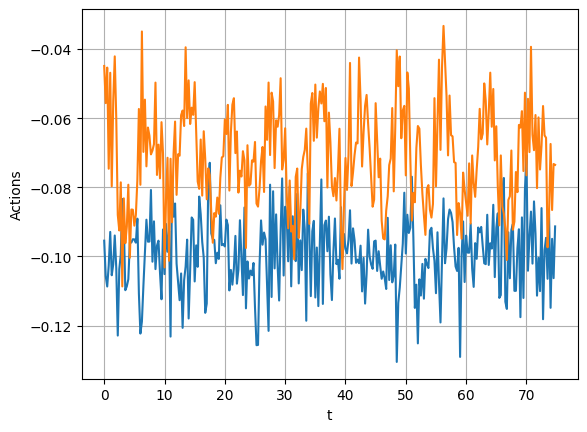

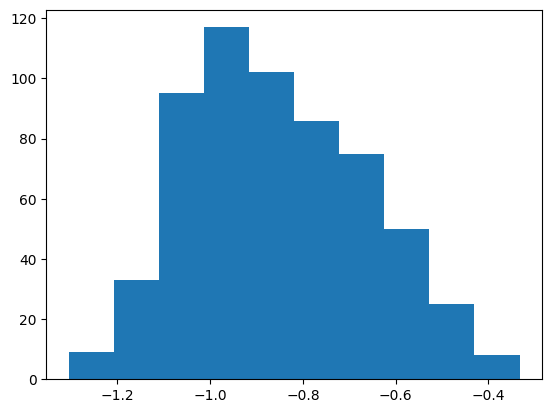

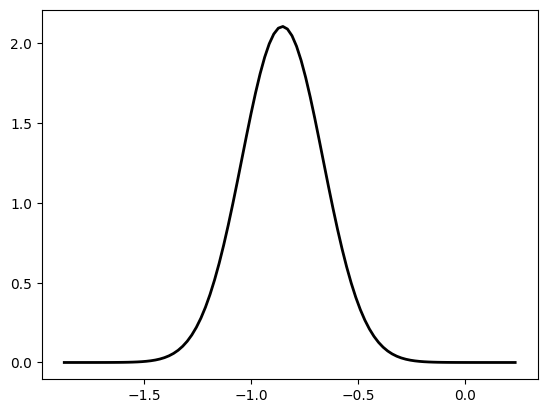

In [72]:
plt.figure()
action_step_dt = 0.25
plt.plot(np.arange(acts_data.shape[0])*action_step_dt,acts_data*0.1)
plt.grid()
plt.xlabel("t")
plt.ylabel("Actions")

plt.figure()
plt.hist(acts_data.flatten())

plt.figure()
from scipy.stats import norm
mu, std = norm.fit(acts_data.flatten())

# Generate points on the x-axis
xmin = acts_data.flatten().min() - 3 * std
xmax = acts_data.flatten().max() + 3 * std
x = np.linspace(xmin, xmax, 100)

# Generate the PDF values
p = norm.pdf(x, mu, std)

# Plot the PDF curve
plt.plot(x, p, 'k', linewidth=2)